In [39]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt

In [40]:
file_path = 'UoB_Set01_2025-05-16LOBs.txt'

In [41]:
# Parsing single-line text
def parse_line_corrected(line):
    line = line.replace('Exch0', "'Exch0'")
    data = ast.literal_eval(line)
    return {
        'timestamp': data[0],
        'exchange': data[1],
        'bids': data[2][0][1],
        'asks': data[2][1][1]
    }

In [42]:
# Parses incoming text line by line
parsed_data_corrected = []
with open(file_path, 'r') as file:
    for line in file:
        parsed_data_corrected.append(parse_line_corrected(line))

In [43]:
df_corrected = pd.DataFrame(parsed_data_corrected)

In [44]:
df_corrected = df_corrected[['exchange', 'timestamp', 'bids', 'asks']]
df_corrected.head()

,exchange,timestamp,bids,asks
0,Exch0,0.000,[],[]
1,Exch0,2.294,[],"[[158, 5]]"
2,Exch0,2.604,"[[1, 9]]","[[158, 5]]"
3,Exch0,3.317,"[[2, 9]]","[[158, 5]]"
4,Exch0,3.968,"[[3, 4], [2, 9]]","[[158, 5]]"


In [45]:
# Sort bids and asks and take the top two
def process_row(row):
    bids_sorted = sorted(row['bids'], key=lambda x: x[0], reverse=True)[:2] if row['bids'] else []
    asks_sorted = sorted(row['asks'], key=lambda x: x[0])[:2] if row['asks'] else []
    return bids_sorted, asks_sorted

In [46]:
df_corrected[['bids', 'asks']] = df_corrected.apply(lambda row: process_row(row), axis=1, result_type='expand')
df_filtered = (df_corrected[(df_corrected['bids'].apply(len) >= 2) & (df_corrected['asks'].apply(len) >= 2)]).reset_index(drop=True)
df_filtered.head()

,exchange,timestamp,bids,asks
0,Exch0,4.309,"[[4, 4], [2, 9]]","[[158, 5], [532, 1]]"
1,Exch0,4.433,"[[5, 9], [4, 4]]","[[158, 5], [532, 1]]"
2,Exch0,4.557,"[[5, 9], [4, 4]]","[[157, 3], [158, 5]]"
3,Exch0,4.743,"[[142, 1], [5, 9]]","[[157, 3], [158, 5]]"
4,Exch0,4.805,"[[142, 1], [5, 9]]","[[157, 3], [158, 5]]"


In [47]:
def remove_max_bid_outliers(bids, mean_price, std_price, threshold=3):
    if not bids:
        return True  
    # Calculate z-score for the maximum bid price
    max_bid_price = max(bid[0] for bid in bids)
    z_score = abs(max_bid_price - mean_price) / std_price
    
    # Return True if the z-score is within the threshold, indicating it's not an outlier
    return z_score <= threshold

# Calculate the mean and standard deviation for the maximum bid prices
max_bid_prices = [max(bid[0] for bid in bids_list) for bids_list in df_filtered['bids'] if bids_list]
mean_max_price = np.mean(max_bid_prices)
std_max_price = np.std(max_bid_prices)

# Filter the DataFrame rows
df_filtered_no_max_outliers = df_filtered[df_filtered['bids'].apply(
    lambda bids: remove_max_bid_outliers(bids, mean_max_price, std_max_price, 3)
)]

# Reset the index after the filter operation
df_filtered_no_max_outliers = df_filtered_no_max_outliers.reset_index(drop=True)

df_filtered_no_max_outliers

,exchange,timestamp,bids,asks
0,Exch0,4.743,"[[142, 1], [5, 9]]","[[157, 3], [158, 5]]"
1,Exch0,4.805,"[[142, 1], [5, 9]]","[[157, 3], [158, 5]]"
2,Exch0,4.836,"[[142, 1], [5, 9]]","[[156, 3], [158, 5]]"
3,Exch0,5.456,"[[127, 1], [81, 1]]","[[135, 1], [155, 3]]"
4,Exch0,5.487,"[[127, 1], [81, 1]]","[[134, 3], [135, 1]]"
...,...,...,...,...
317338,Exch0,30599.542,"[[132, 5], [131, 2]]","[[141, 1], [142, 1]]"
317339,Exch0,30599.790,"[[132, 5], [131, 2]]","[[141, 1], [142, 1]]"
317340,Exch0,30599.821,"[[132, 5], [131, 2]]","[[141, 1], [142, 1]]"
317341,Exch0,30599.945,"[[132, 5], [131, 2]]","[[141, 1], [444, 5]]"


In [48]:
def remove_min_bid_outliers(bids, mean_min_price, std_min_price, threshold=3):
    if not bids:
        return True
    min_bid_price = min(bid[0] for bid in bids)
    z_score = (min_bid_price - mean_min_price) / std_min_price
    return abs(z_score) <= threshold

# Calculate mean and standard deviation for the minimum bid prices across the DataFrame
min_bid_prices = [min(bid[0] for bid in bids_list) for bids_list in df_filtered_no_max_outliers['bids'] if bids_list]
mean_min_price = np.mean(min_bid_prices)
std_min_price = np.std(min_bid_prices)

# Apply the outlier removal function to each row
df_filtered_no_min_outliers = df_filtered_no_max_outliers[df_filtered_no_max_outliers['bids'].apply(
    lambda bids: remove_min_bid_outliers(bids, mean_min_price, std_min_price, 3)
)]

# Reset index
df_filtered_no_min_outliers.reset_index(drop=True, inplace=True)

# Display the first few rows
df_filtered_no_min_outliers

,exchange,timestamp,bids,asks
0,Exch0,5.611,"[[128, 4], [127, 1]]","[[134, 3], [135, 1]]"
1,Exch0,6.851,"[[129, 4], [128, 1]]","[[130, 3], [132, 1]]"
2,Exch0,6.882,"[[129, 4], [128, 1]]","[[130, 3], [132, 1]]"
3,Exch0,6.944,"[[129, 1], [128, 1]]","[[132, 1], [134, 3]]"
4,Exch0,7.161,"[[129, 1], [128, 1]]","[[132, 5], [134, 3]]"
...,...,...,...,...
308497,Exch0,30599.542,"[[132, 5], [131, 2]]","[[141, 1], [142, 1]]"
308498,Exch0,30599.790,"[[132, 5], [131, 2]]","[[141, 1], [142, 1]]"
308499,Exch0,30599.821,"[[132, 5], [131, 2]]","[[141, 1], [142, 1]]"
308500,Exch0,30599.945,"[[132, 5], [131, 2]]","[[141, 1], [444, 5]]"


In [49]:
def remove_min_ask_outliers(asks, mean_price, std_price, threshold=3):
    if not asks:
        return True  # Keep rows with no asks as they're not outliers
    min_ask_price = min(ask[0] for ask in asks)
    z_score = (min_ask_price - mean_price) / std_price
    return abs(z_score) <= threshold

# Calculate mean and standard deviation for minimum ask prices
min_ask_prices = [min(ask[0] for ask in asks_list) for asks_list in df_filtered['asks'] if asks_list]
mean_min_ask_price = np.mean(min_ask_prices)
std_min_ask_price = np.std(min_ask_prices)

# Apply the function to filter rows based on minimum ask price outliers
df_filtered_no_min_ask_outliers = df_filtered_no_min_outliers[df_filtered_no_min_outliers['asks'].apply(
    lambda asks: remove_min_ask_outliers(asks, mean_min_ask_price, std_min_ask_price, 3)
)]

# Reset the index after filtering
df_filtered_no_min_ask_outliers.reset_index(drop=True, inplace=True)

df_filtered_no_min_ask_outliers

,exchange,timestamp,bids,asks
0,Exch0,5.611,"[[128, 4], [127, 1]]","[[134, 3], [135, 1]]"
1,Exch0,6.851,"[[129, 4], [128, 1]]","[[130, 3], [132, 1]]"
2,Exch0,6.882,"[[129, 4], [128, 1]]","[[130, 3], [132, 1]]"
3,Exch0,6.944,"[[129, 1], [128, 1]]","[[132, 1], [134, 3]]"
4,Exch0,7.161,"[[129, 1], [128, 1]]","[[132, 5], [134, 3]]"
...,...,...,...,...
300088,Exch0,30599.542,"[[132, 5], [131, 2]]","[[141, 1], [142, 1]]"
300089,Exch0,30599.790,"[[132, 5], [131, 2]]","[[141, 1], [142, 1]]"
300090,Exch0,30599.821,"[[132, 5], [131, 2]]","[[141, 1], [142, 1]]"
300091,Exch0,30599.945,"[[132, 5], [131, 2]]","[[141, 1], [444, 5]]"


In [50]:
def remove_max_ask_outlier(asks, mean_price, std_price, threshold=3):
    if not asks:
        return True
    max_ask_price = max(ask[0] for ask in asks)
    z_score = (max_ask_price - mean_price) / std_price
    return abs(z_score) <= threshold

# Calculate mean and standard deviation for maximum ask prices
max_ask_prices = [max(ask[0] for ask in asks_list) for asks_list in df_filtered_no_min_ask_outliers['asks'] if asks_list]
mean_max_ask_price = np.mean(max_ask_prices)
std_max_ask_price = np.std(max_ask_prices)

# Apply the function to filter rows based on maximum ask price outliers
df_filtered_no_max_ask_outliers = df_filtered_no_min_ask_outliers[df_filtered_no_min_ask_outliers['asks'].apply(
    lambda asks: remove_max_ask_outlier(asks, mean_max_ask_price, std_max_ask_price, 3)
)]

# Reset the index after filtering
df_filtered_no_max_ask_outliers.reset_index(drop=True, inplace=True)

df_filtered_no_max_ask_outliers

,exchange,timestamp,bids,asks
0,Exch0,5.611,"[[128, 4], [127, 1]]","[[134, 3], [135, 1]]"
1,Exch0,6.851,"[[129, 4], [128, 1]]","[[130, 3], [132, 1]]"
2,Exch0,6.882,"[[129, 4], [128, 1]]","[[130, 3], [132, 1]]"
3,Exch0,6.944,"[[129, 1], [128, 1]]","[[132, 1], [134, 3]]"
4,Exch0,7.161,"[[129, 1], [128, 1]]","[[132, 5], [134, 3]]"
...,...,...,...,...
294447,Exch0,30599.542,"[[132, 5], [131, 2]]","[[141, 1], [142, 1]]"
294448,Exch0,30599.790,"[[132, 5], [131, 2]]","[[141, 1], [142, 1]]"
294449,Exch0,30599.821,"[[132, 5], [131, 2]]","[[141, 1], [142, 1]]"
294450,Exch0,30599.945,"[[132, 5], [131, 2]]","[[141, 1], [444, 5]]"


In [51]:
def split_bids_asks(row):
    # Splitting bids into prices and sizes
    bid_price1, bid_size1 = row['bids'][0]
    bid_price2, bid_size2 = row['bids'][1]
    ask_price1, ask_size1 = row['asks'][0]
    ask_price2, ask_size2 = row['asks'][1]  
    return pd.Series([bid_price1, bid_price2, bid_size1, bid_size2, ask_price1, ask_price2, ask_size1, ask_size2])

# Apply the function to each row of the DataFrame and create new columns
df_final_filtered = df_filtered_no_max_ask_outliers.copy()
df_final_filtered[['bid_price1', 'bid_price2', 'bid_size1', 'bid_size2', 'ask_price1', 'ask_price2', 'ask_size1', 'ask_size2']] = df_final_filtered.apply(split_bids_asks, axis=1)
df_final_filtered.drop(['bids', 'asks'], axis=1, inplace=True)

# Display the first few rows of the DataFrame to verify the changes
df_final_filtered

,exchange,timestamp,bid_price1,bid_price2,bid_size1,bid_size2,ask_price1,ask_price2,ask_size1,ask_size2
0,Exch0,5.611,128,127,4,1,134,135,3,1
1,Exch0,6.851,129,128,4,1,130,132,3,1
2,Exch0,6.882,129,128,4,1,130,132,3,1
3,Exch0,6.944,129,128,1,1,132,134,1,3
4,Exch0,7.161,129,128,1,1,132,134,5,3
...,...,...,...,...,...,...,...,...,...,...
294447,Exch0,30599.542,132,131,5,2,141,142,1,1
294448,Exch0,30599.790,132,131,5,2,141,142,1,1
294449,Exch0,30599.821,132,131,5,2,141,142,1,1
294450,Exch0,30599.945,132,131,5,2,141,444,1,5


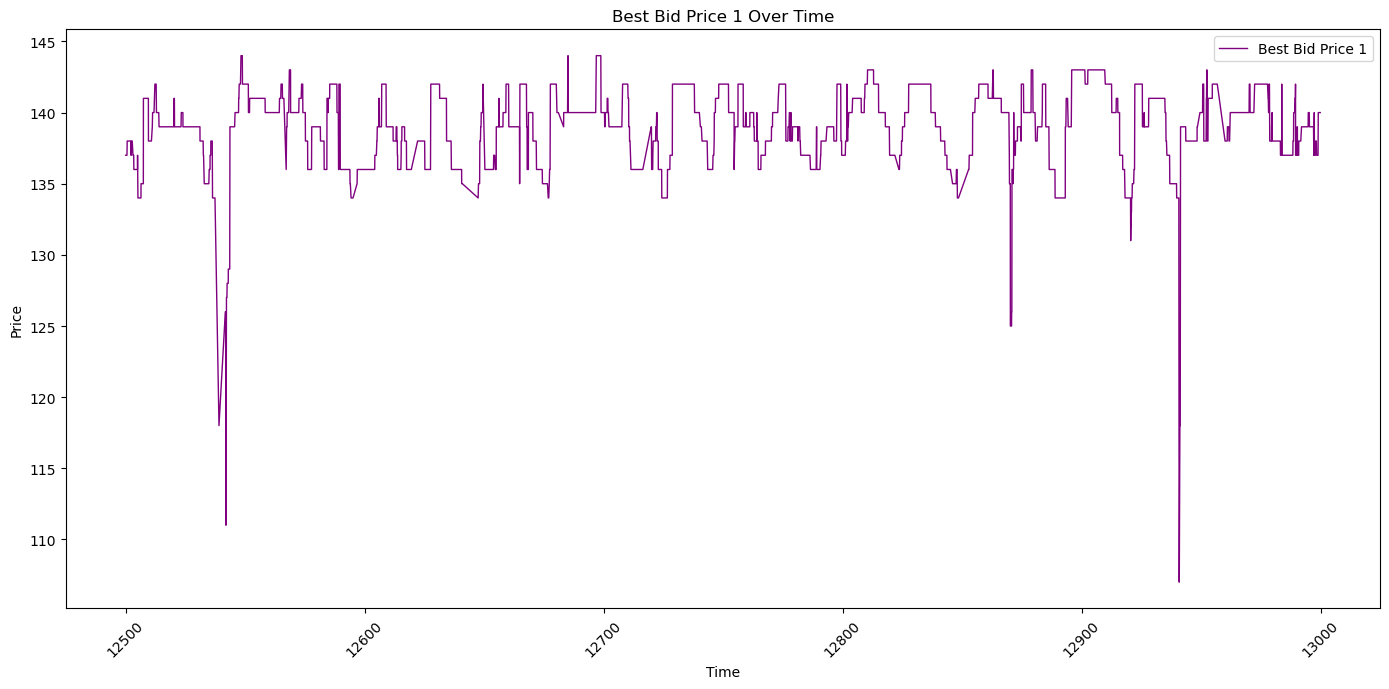

In [52]:
# Bid_price1 over Time

# Filtering data, timestamp between m and n
zoomin_filtered_df = df_final_filtered[(df_final_filtered['timestamp'] >= 12500) & (df_final_filtered['timestamp'] <= 13000)]

# Set the graphic size
plt.figure(figsize=(14, 7))

# Plot time series of best-buy prices
plt.plot(zoomin_filtered_df['timestamp'], zoomin_filtered_df['bid_price1'], label='Best Bid Price 1', color='purple', linewidth=1)

# Add some details on the graph
plt.title('Best Bid Price 1 Over Time')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels to improve visibility
plt.tight_layout()  # Automatically adjust sub-map parameters to fill the entire image area

# Display the graph
plt.show()


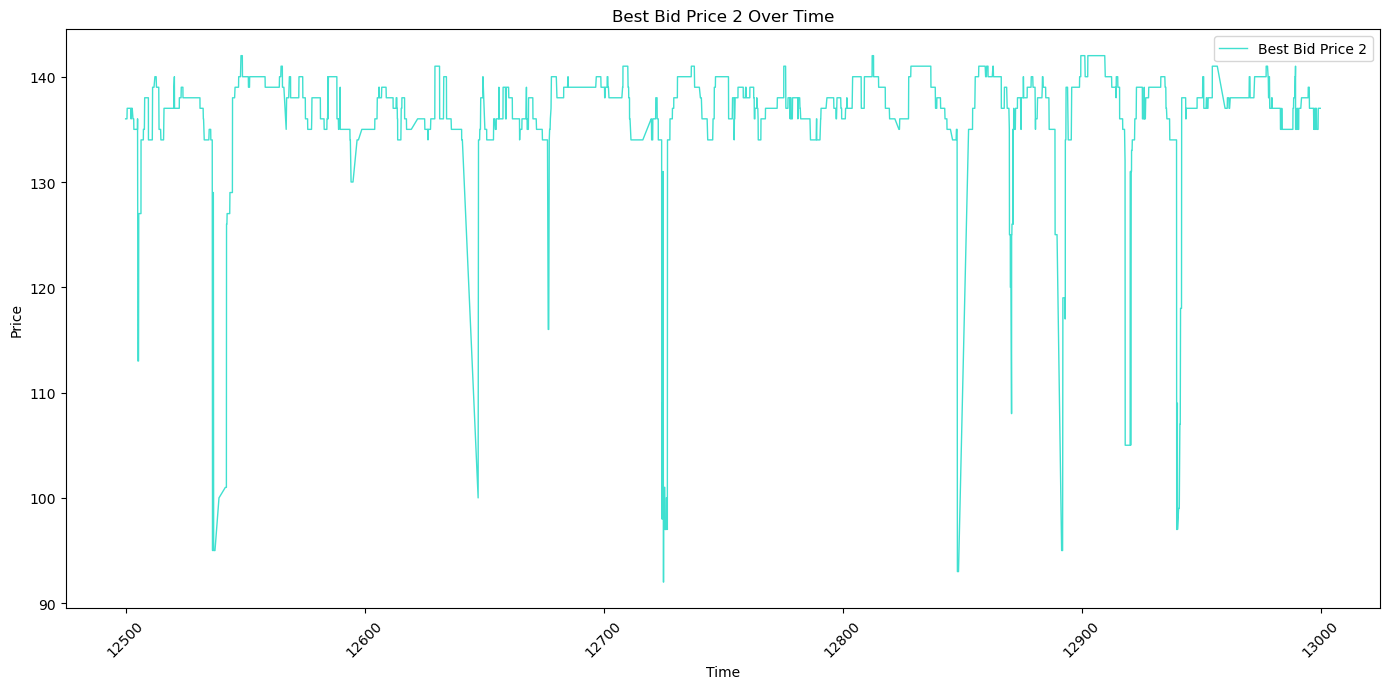

In [53]:
# Bid_price2 over Time

# Filtering data, timestamp between m and n
zoomin_filtered_df = df_final_filtered[(df_final_filtered['timestamp'] >= 12500) & (df_final_filtered['timestamp'] <= 13000)]

# Set the graphic size
plt.figure(figsize=(14, 7))

# Plot time series of best-buy prices
plt.plot(zoomin_filtered_df['timestamp'], zoomin_filtered_df['bid_price2'], label='Best Bid Price 2', color='turquoise', linewidth=1)

# Add some details on the graph
plt.title('Best Bid Price 2 Over Time')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels to improve visibility
plt.tight_layout()  # Automatically adjust sub-map parameters to fill the entire image area

# Display the graph
plt.show()


C:\Users\zoec0\AppData\Local\Temp\ipykernel_3996\1281655978.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zoomin_filtered_df['spread1'] = zoomin_filtered_df['ask_price1'] - zoomin_filtered_df['bid_price1']


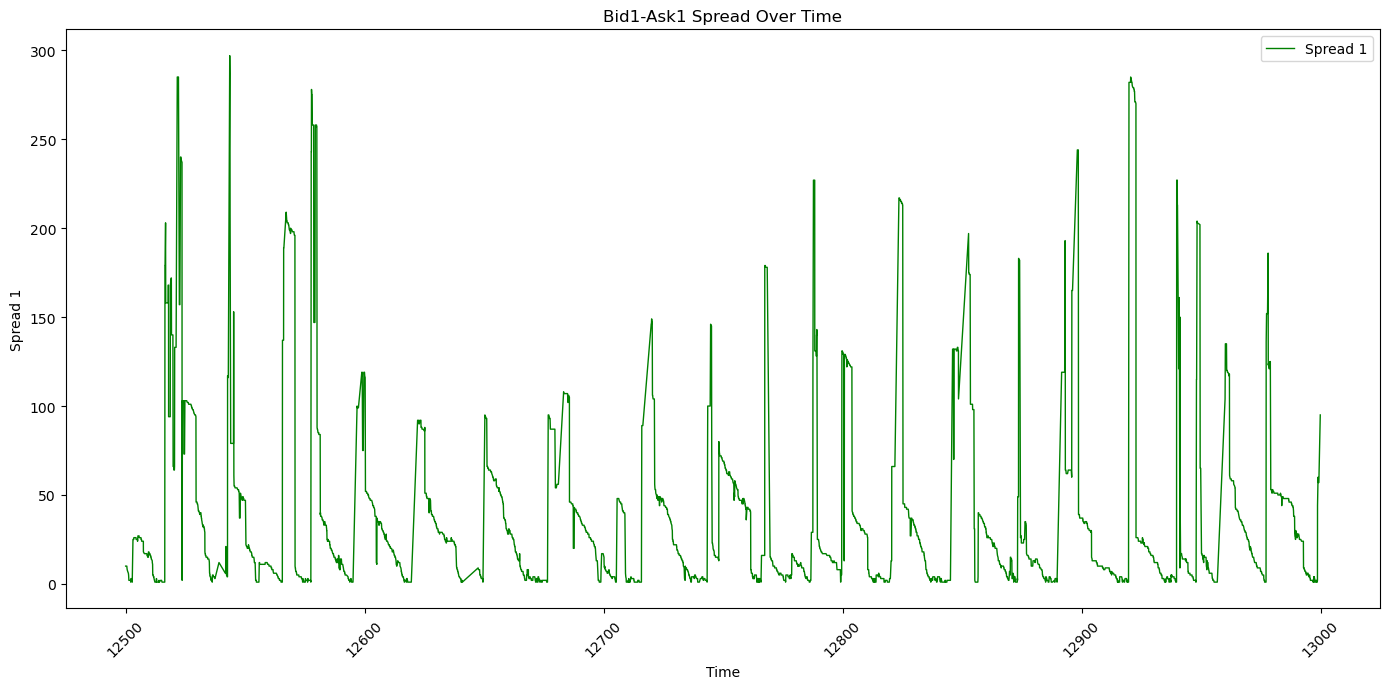

In [54]:
# spread1 = ask_price1 - bid_price1

# Filtering data, timestamp between m and n
zoomin_filtered_df = df_final_filtered[(df_final_filtered['timestamp'] >= 12500) & (df_final_filtered['timestamp'] <= 13000)]

# Calculate Spread1
zoomin_filtered_df['spread1'] = zoomin_filtered_df['ask_price1'] - zoomin_filtered_df['bid_price1']

# Set the graphic size
plt.figure(figsize=(14, 7))

# Draw Spread1
plt.plot(zoomin_filtered_df['timestamp'], zoomin_filtered_df['spread1'], label='Spread 1', linewidth=1, color='green')

# Add some details on the graph
plt.title('Bid1-Ask1 Spread Over Time')
plt.xlabel('Time')
plt.ylabel('Spread 1')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels to improve visibility
plt.tight_layout()  # Automatically adjust sub-map parameters to fill the entire image area

# Display the graph
plt.show()


C:\Users\zoec0\AppData\Local\Temp\ipykernel_3996\997290921.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zoomin_filtered_df['spread2'] = zoomin_filtered_df['ask_price2'] - zoomin_filtered_df['bid_price2']


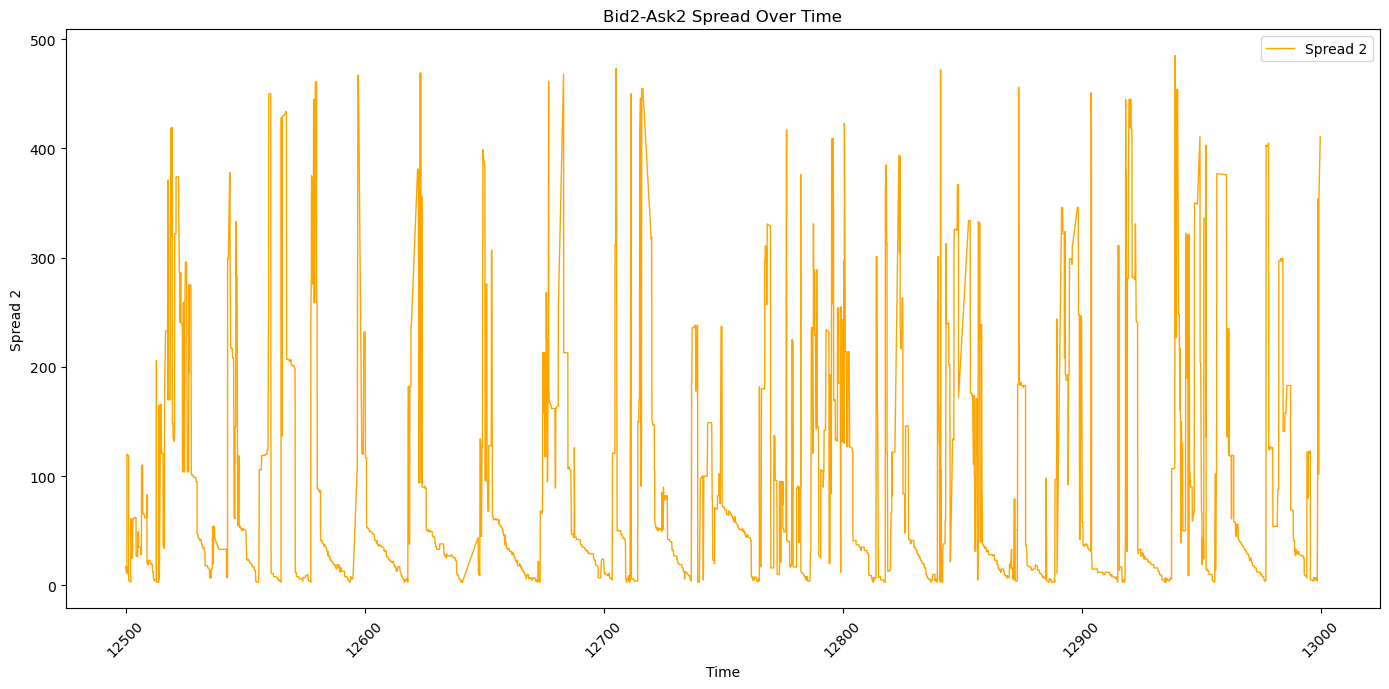

In [55]:
# spread2 = ask_price1=2 - bid_price2

# Filtering data, timestamp between m and n
zoomin_filtered_df = df_final_filtered[(df_final_filtered['timestamp'] >= 12500) & (df_final_filtered['timestamp'] <= 13000)]

# Calculate Spread2
zoomin_filtered_df['spread2'] = zoomin_filtered_df['ask_price2'] - zoomin_filtered_df['bid_price2']

# Set the graphic size
plt.figure(figsize=(14, 7))

# Draw Spread2
plt.plot(zoomin_filtered_df['timestamp'], zoomin_filtered_df['spread2'], label='Spread 2', linewidth=1, color='orange')

# Add some details on the graph
plt.title('Bid2-Ask2 Spread Over Time')
plt.xlabel('Time')
plt.ylabel('Spread 2')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels to improve visibility
plt.tight_layout()  # Automatically adjust sub-map parameters to fill the entire image area

# Display the graph
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


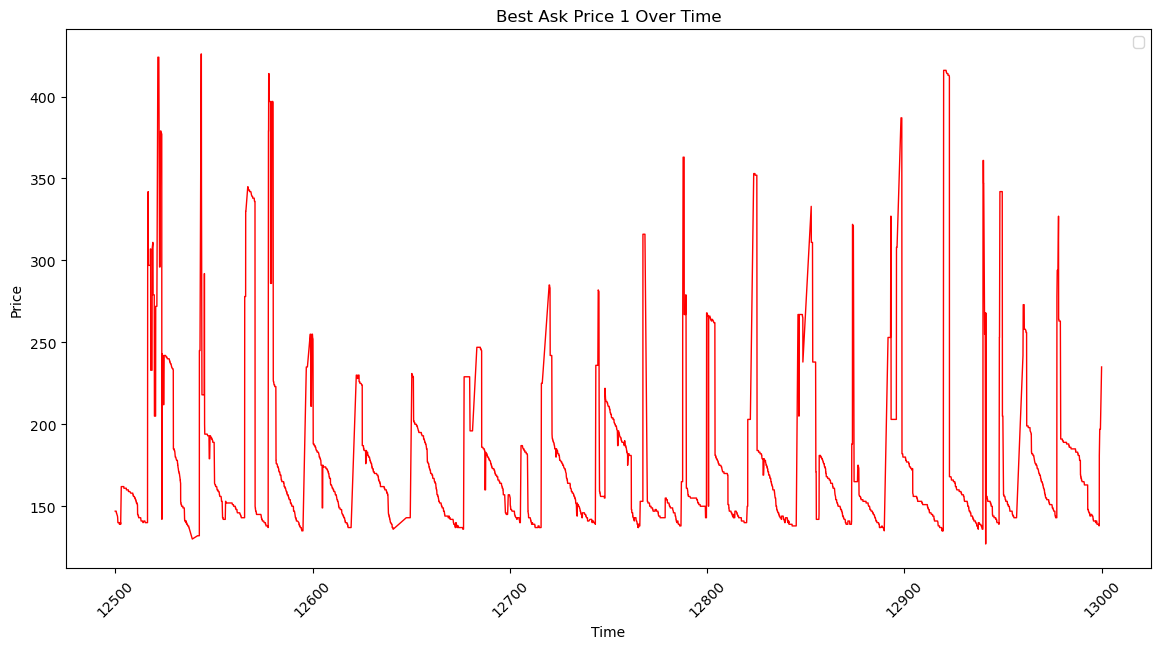

In [56]:
# Filtering data, timestamp between m and n
zoomin_filtered_df = df_final_filtered[(df_final_filtered['timestamp'] >= 12500) & (df_final_filtered['timestamp'] <= 13000)]

# Set the figure size for better visibility
plt.figure(figsize=(14, 7))

# Plot the best ask price over time
plt.plot(zoomin_filtered_df['timestamp'], zoomin_filtered_df['ask_price1'], color='red', linewidth=1)

# Beautify the plot with title, labels, and legend
plt.title('Best Ask Price 1 Over Time')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability

# Show the plot
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


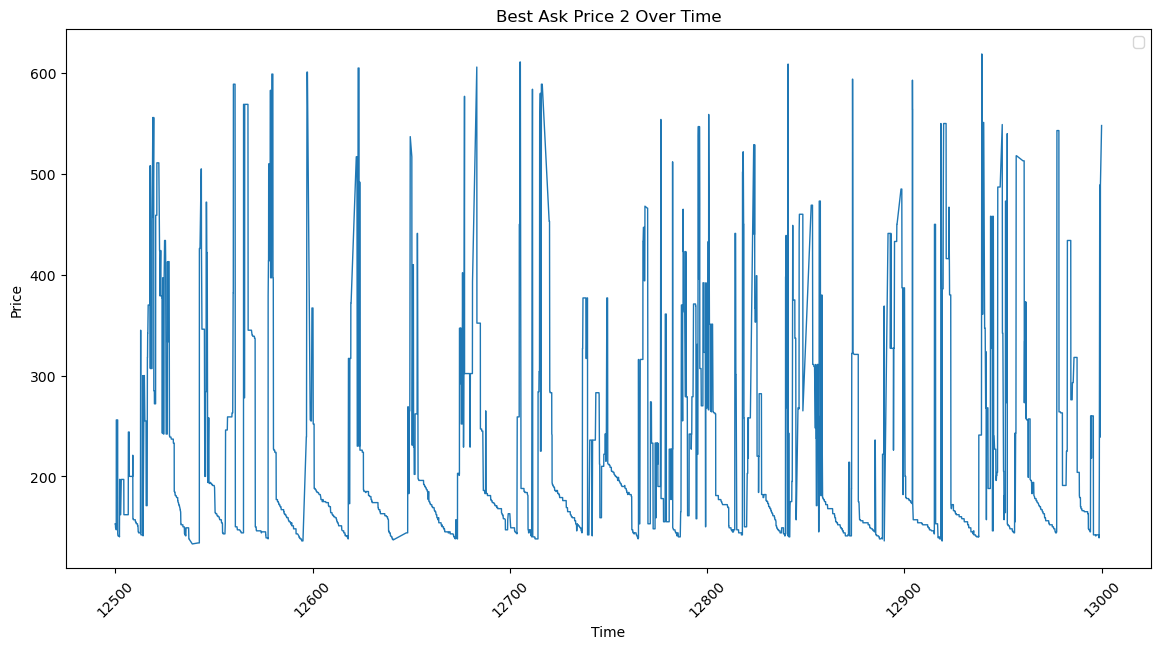

In [57]:
# Filtering data, timestamp between m and n
zoomin_filtered_df = df_final_filtered[(df_final_filtered['timestamp'] >= 12500) & (df_final_filtered['timestamp'] <= 13000)]

# Set the figure size for better visibility
plt.figure(figsize=(14, 7))

# Plot the best ask price over time
plt.plot(zoomin_filtered_df['timestamp'], zoomin_filtered_df['ask_price2'], linewidth=1)

# Beautify the plot with title, labels, and legend
plt.title('Best Ask Price 2 Over Time')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability

# Show the plot
plt.show()


C:\Users\zoec0\AppData\Local\Temp\ipykernel_3996\631702805.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zoomin_filtered_df['total_bid_size'] = zoomin_filtered_df['bid_size1'] + zoomin_filtered_df['bid_size2']
C:\Users\zoec0\AppData\Local\Temp\ipykernel_3996\631702805.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zoomin_filtered_df['total_ask_size'] = zoomin_filtered_df['ask_size1'] + zoomin_filtered_df['ask_size2']


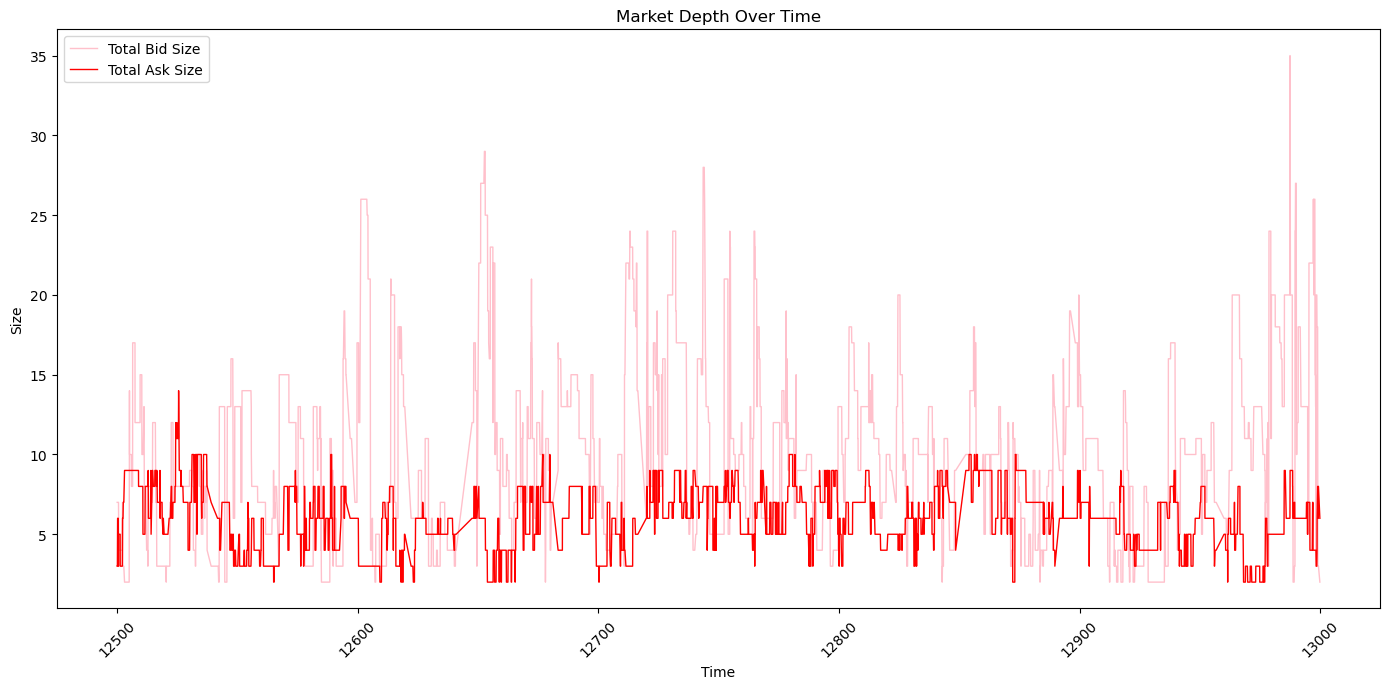

In [64]:
# Filtering data, timestamp between m and n
zoomin_filtered_df = df_final_filtered[(df_final_filtered['timestamp'] >= 12500) & (df_final_filtered['timestamp'] <= 13000)]

# Calculate total_bid_size and total_ask_size at each point in time
zoomin_filtered_df['total_bid_size'] = zoomin_filtered_df['bid_size1'] + zoomin_filtered_df['bid_size2']
zoomin_filtered_df['total_ask_size'] = zoomin_filtered_df['ask_size1'] + zoomin_filtered_df['ask_size2']

# Set the graphic size
plt.figure(figsize=(14, 7))

# Plot the change in market depth
plt.plot(zoomin_filtered_df['timestamp'], zoomin_filtered_df['total_bid_size'], label='Total Bid Size', linewidth=1, color='pink')
plt.plot(zoomin_filtered_df['timestamp'], zoomin_filtered_df['total_ask_size'], label='Total Ask Size', linewidth=1, color='red')

# Add some details on the graph
plt.title('Market Depth Over Time')
plt.xlabel('Time')
plt.ylabel('Size')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()
